<a href="https://colab.research.google.com/github/danielje679/medVAE/blob/main/train_and_evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## VAE-based Medical Image Generator

### Data loading

In [ ]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116932 sha256=6dda62690dd8ca1ecb1bff5b6169a06d103aa1da383b7d8543dfbbe405a31cd7
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


In [ ]:
from tqdm import tqdm # progress indication
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [ ]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.2.2 @ https://github.com/MedMNIST/MedMNIST/


Reading the data

In [ ]:
data_flag = 'chestmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

Read the MNIST data, preprocess it and put in dataloader

In [ ]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Using downloaded and verified file: /root/.medmnist/chestmnist.npz


In [ ]:
print(train_dataset)
print("=================")
print(test_dataset)

Dataset ChestMNIST (chestmnist)
    Number of datapoints: 78468
    Root location: /root/.medmnist
    Split: train
    Task: multi-label, binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'atelectasis', '1': 'cardiomegaly', '2': 'effusion', '3': 'infiltration', '4': 'mass', '5': 'nodule', '6': 'pneumonia', '7': 'pneumothorax', '8': 'consolidation', '9': 'edema', '10': 'emphysema', '11': 'fibrosis', '12': 'pleural', '13': 'hernia'}
    Number of samples: {'train': 78468, 'val': 11219, 'test': 22433}
    Description: The ChestMNIST is based on the NIH-ChestXray14 dataset, a dataset comprising 112,120 frontal-view X-Ray images of 30,805 unique patients with the text-mined 14 disease labels, which could be formulized as a multi-label binary-class classification task. We use the official data split, and resize the source images of 1×1024×1024 into 1×28×28.
    License: CC BY 4.0
Dataset ChestMNIST (chestmnist)
    Number of datapoints: 22433
    Root location: /root/.medm

In [ ]:
print(n_channels)

1


/usr/local/lib/python3.10/dist-packages/medmnist/utils.py:31: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


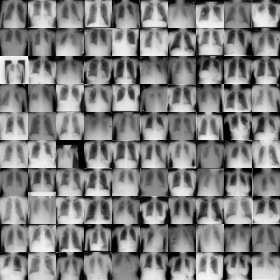

In [ ]:
# visualization
train_dataset.montage(length=10)

# VAE implementation

The end goal is to minimize this function:

$$
\color{red}{\min \mathbb{E}_{q}[ \log q(z|x) - \log p(z)]} - \color{blue}{\mathbb{E}_{q} \log p(x|z)}
$$

In [ ]:
from torch.nn.modules.activation import LeakyReLU
from torch.nn.modules.batchnorm import BatchNorm2d
from torch.nn import functional as F

class VanillaVAE(nn.Module):
  def __init__(self, in_channels: int, latent_dim: int, hidden_dims: list = None, **kwargs) -> None:
    super().__init__()

    self.latent_dim = latent_dim

    modules = []
    if hidden_dims is None:
      hidden_dims = [32, 64, 128, 256, 512]

    # Encoder
    for h_dim in hidden_dims:
      modules.append(
          nn.Sequential(
              nn.Conv2d(in_channels, out_channels=h_dim, kernel_size=3,
                        stride=2, padding=1),
              nn.BatchNorm2d(h_dim),
              nn.LeakyReLU()
          )
      )
      in_channels = h_dim

    self.encoder = nn.Sequential(*modules) # multiple conv2d -> batchnorm -> relu layers
    self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim) # size 4*512=2048
    self.fc_var = nn.Linear(hidden_dims[-1], latent_dim) # size 4*512=2048

    # Decoder
    modules = []

    self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1]*4)
    hidden_dims.reverse()

    for i in range(len(hidden_dims)-1):
      modules.append(
          nn.Sequential(
              nn.ConvTranspose2d(hidden_dims[i],
                                 hidden_dims[i+1],
                                 kernel_size=3,
                                 stride=2,
                                 padding=1,
                                 output_padding=1
                                 ),
              nn.BatchNorm2d(hidden_dims[i+1]),
              nn.LeakyReLU()
          )
      )

    self.decoder = nn.Sequential(*modules)

    """self.final_layer = nn.Sequential(
        nn.ConvTranspose2d(hidden_dims[-1],
                           hidden_dims[-1],
                           kernel_size=3,
                           stride=2,
                           padding=1,
                           output_padding=1),
        nn.BatchNorm2d(hidden_dims[-1]),
        nn.LeakyReLU(),
        nn.Conv2d(hidden_dims[-1], out_channels=1, kernel_size=3, padding=1),
        nn.Tanh()
    )"""
    self.final_layer = nn.Sequential(
        nn.BatchNorm2d(32),
        nn.LeakyReLU(),
        nn.Conv2d(32, out_channels=1, kernel_size=5),
        nn.Tanh()
    )

  def encode(self, input):
    result = self.encoder(input)
    result = torch.flatten(result, start_dim=1)

    # mu and var of resulting latent gaussian
    mu = self.fc_mu(result)
    log_var = self.fc_var(result)

    return [mu, log_var]

  def decode(self, z):
    result = self.decoder_input(z)
    result = result.view(-1, 512, 2, 2)
    result = self.decoder(result)
    result = self.final_layer(result)

    return result

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return eps * std + mu

  def forward(self, input, **kwargs):
    mu, log_var = self.encode(input)
    z = self.reparameterize(mu, log_var)
    return [self.decode(z), input, mu, log_var]


  def loss_function(self, *args, **kwargs) -> dict:
    recons = args[0]
    input = args[1]
    mu = args[2]
    log_var = args[3]

    kld_weight = kwargs['M_N']
    recons_loss = F.mse_loss(recons, input)

    kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp(), dim=1), dim=0)

    loss = recons_loss + kld_weight * kld_loss
    return {'loss': loss, 'Reconstruction_loss': recons_loss.detach(), 'KLD': -kld_loss.detach()}

  def sample(self, num_samples:int, current_device: int, **kwargs):
    z = torch.randn(num_samples, self.latent_dim)

    z = z.to(current_device)

    samples = self.decode(z)
    return samples

  def generate(self, x, **kwargs):
    self.forward(x)[0]

## Training Configuration

In [ ]:
# Config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

INPUT_DIM = 784
Z_DIM = 128
H_DIM = 200
NUM_EPOCHS = 25
BATCH_SIZE = 32
LR_RATE = 3e-4
KLD_WEIGHTS = 0.00025

cuda


## Training

In [ ]:
x_example, y_example = train_dataset[0]
val_sample, label = val_dataset[0]

print(x_example.shape)
print(val_sample.shape)

torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


In [ ]:
def train(num_epochs, model, optimizer):
  loss_per_epoch = []

  validation_image, label = val_dataset[0]
  validation_image = validation_image.unsqueeze(0)
  reconstructed_images = []

  for epoch in range(num_epochs):
    running_loss = 0.0

    model.train()
    for x, y in tqdm(train_loader):
      # forward pass
      x = x.to(device)#.view(-1, INPUT_DIM)
      x_reconst, input, mu, log_var = (*model(x),)


      # loss
      loss = model.loss_function(x_reconst, input, mu, log_var, M_N=KLD_WEIGHTS)['loss']
      running_loss += loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    avg_loss = running_loss / len(train_loader)
    print(avg_loss)
    loss_per_epoch.append(avg_loss)
    running_loss = 0.0

    model.eval()
    validation_image.to(device)
    x_reconst, input, mu, log_var = model(validation_image.cuda())
    reconstructed_images.append(x_reconst)


    #print(avg_loss)
  return loss_per_epoch, reconstructed_images, validation_image

In [ ]:
model = VanillaVAE(in_channels=n_channels, latent_dim=Z_DIM)
if torch.cuda.is_available():
    model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=LR_RATE)

# run training
loss_per_epoch, reconst_imgs, val_img = train(NUM_EPOCHS, model, optimizer)

100%|██████████| 2453/2453 [00:45<00:00, 54.43it/s]


0.034688381272411035


100%|██████████| 2453/2453 [00:43<00:00, 56.03it/s]


0.024414009100628832


100%|██████████| 2453/2453 [00:41<00:00, 59.71it/s]


0.022755511534843356


100%|██████████| 2453/2453 [00:42<00:00, 57.57it/s]


0.02161744607804602


100%|██████████| 2453/2453 [00:42<00:00, 57.86it/s]


0.020821782797909104


100%|██████████| 2453/2453 [00:41<00:00, 59.49it/s]


0.020355834963944462


100%|██████████| 2453/2453 [00:41<00:00, 59.07it/s]


0.019942944565665657


100%|██████████| 2453/2453 [00:41<00:00, 59.47it/s]


0.01961518840122432


100%|██████████| 2453/2453 [00:41<00:00, 59.69it/s]


0.019355775316120944


100%|██████████| 2453/2453 [00:41<00:00, 59.19it/s]


0.01911939943989126


100%|██████████| 2453/2453 [00:41<00:00, 58.56it/s]


0.01890360446752357


100%|██████████| 2453/2453 [00:41<00:00, 59.41it/s]


0.01871833969074648


100%|██████████| 2453/2453 [00:41<00:00, 59.08it/s]


0.01856878655022971


100%|██████████| 2453/2453 [00:42<00:00, 57.83it/s]


0.018428235776081554


100%|██████████| 2453/2453 [00:41<00:00, 59.57it/s]


0.018328478644517334


100%|██████████| 2453/2453 [00:40<00:00, 60.49it/s]


0.018222251355714862


100%|██████████| 2453/2453 [00:40<00:00, 60.23it/s]


0.01810920149159283


100%|██████████| 2453/2453 [00:41<00:00, 58.91it/s]


0.018038006970576132


100%|██████████| 2453/2453 [00:40<00:00, 59.98it/s]


0.017953418513028733


100%|██████████| 2453/2453 [00:40<00:00, 60.06it/s]


0.01786060714498132


100%|██████████| 2453/2453 [00:40<00:00, 60.86it/s]


0.017768404591574968


100%|██████████| 2453/2453 [00:41<00:00, 59.05it/s]


0.01772785313424411


100%|██████████| 2453/2453 [00:40<00:00, 60.51it/s]


0.017673029160355604


100%|██████████| 2453/2453 [00:40<00:00, 60.33it/s]


0.017602577626316392


100%|██████████| 2453/2453 [00:40<00:00, 59.95it/s]

0.0175218562953572


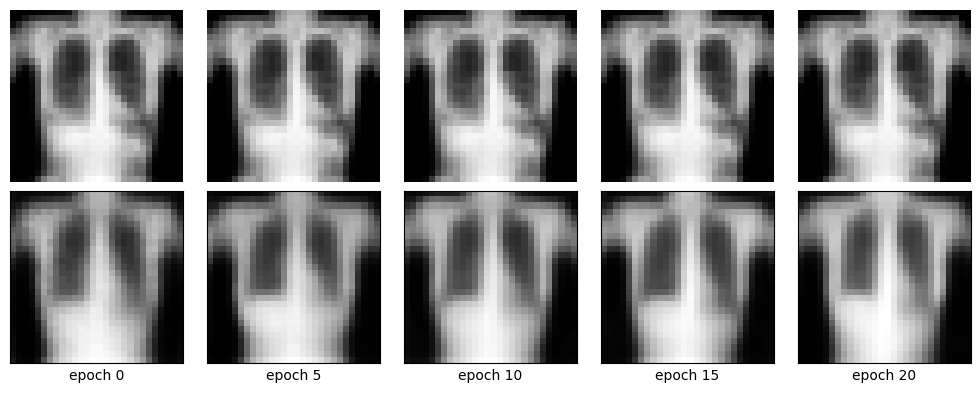

In [ ]:
import matplotlib.pyplot as plt

def plot_image_grid(original_image, reconstructed_images):
    num_images = len(reconstructed_images)
    num_plotted_imgs = 5
    fig, axes = plt.subplots(2, num_plotted_imgs, figsize=(10, 4))

    original_image_reshaped = original_image[0].permute(1, 2, 0)

    # Plot original image multiple times on the top row
    for i in range(num_plotted_imgs):
        axes[0, i].imshow(original_image_reshaped, cmap='gray')
        axes[0, i].set_axis_off()

    # Plot reconstructed images on the bottom row
    for i in range(0, num_images, 5):

        reconstructed_image = reconstructed_images[i].cpu()[0]
        reconstructed_image = reconstructed_image.permute(1, 2, 0)
        reconstructed_image = reconstructed_image.detach().numpy()
        axes[1, int(i/5)].imshow(reconstructed_image, cmap='gray')
        axes[1, int(i/5)].set_xlabel(f'epoch {i}')
        axes[1, int(i/5)].get_xaxis().set_ticks([])#set_axis_off()
        axes[1, int(i/5)].get_yaxis().set_ticks([])


    plt.tight_layout()
    plt.show()

# Usage example
plot_image_grid(val_img, reconst_imgs)

Text(0.5, 0, 'epochs')

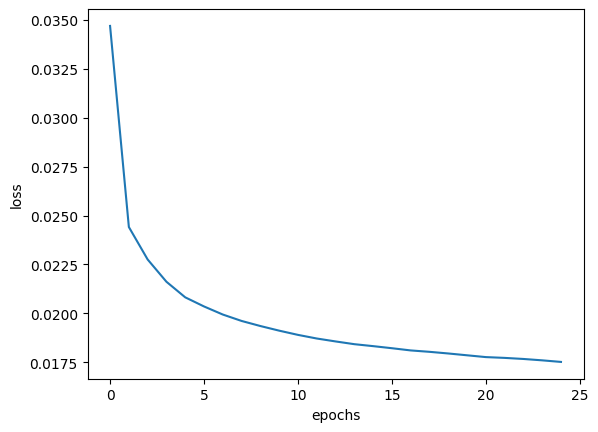

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_per_epoch)
plt.ylabel('loss')
plt.xlabel('epochs')

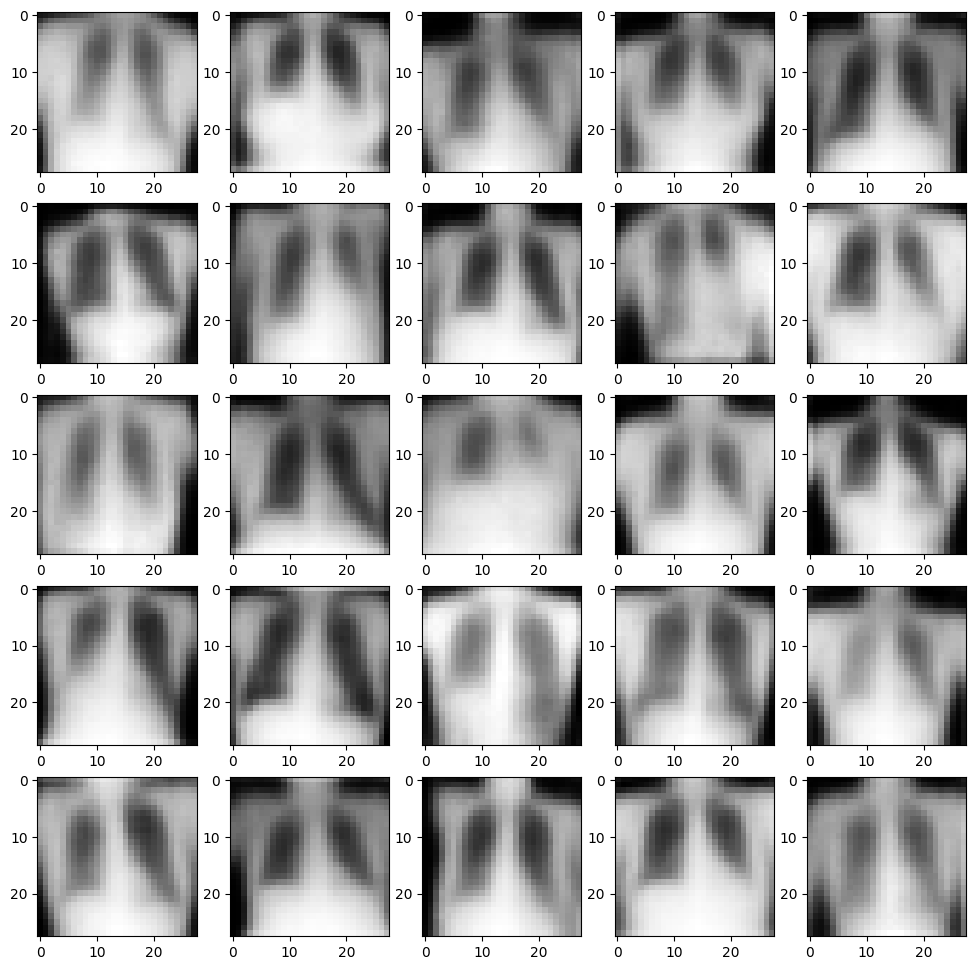

In [ ]:
samples = model.sample(25, device)

imgs = samples.cpu()

_, axs = plt.subplots(5, 5, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    img = img.permute(1, 2, 0)
    img = img.detach().numpy()
    ax.imshow(img, cmap="gray")
plt.show()